Lelong Clément

Duchemin Thomas

In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.svm
import os
import matplotlib.pyplot as plt

%matplotlib inline

### Importation des données

Nous n'avons utilisé pour l'entrainement que les tiles qui étaient annotées individuellement. Nous avons donc séparé manuellement les features des tiles annotées, que nous avons placé dans un nouveau dossier "resnet_features_annotated".

In [2]:
path=".\\data"
train_folder=path+"\\train_input\\resnet_features_annotated"
test_folder=path+"\\test_input\\resnet_features"

On crée d'abord un array X qui contient les features de chaque tile.

In [3]:
X=np.empty(shape=(0,2051))
for element in os.listdir(train_folder):
    X = np.concatenate((X,np.load(train_folder+"\\"+element)),axis=0)
print(X.shape)

(10124, 2051)


On importe ensuite les labels de chaque tile dans une Dataframe pandas Y. On récupére aussi pour chaque tile son numéro, ainsi que le numéro de la slide à laquelle elle appartient. Cela nous permet d'ordonner Y de la même façon que X.

On récupére ensuite dans un vecteur label les labels de chaque tile.

In [4]:
def get_slide_number(a):
    nb_slide = int(a[3:6])
    return(nb_slide)

def get_tile_number(a):
    if a[23]=="_":
        nb_tile=int(a[22])
    elif a[24]=="_":
        nb_tile=int(a[22:24])
    else:
        nb_tile = int(a[22:25])
    return(nb_tile)


Y = pd.read_csv(path+'\\train_input\\train_tile_annotations.csv')
Y['SlideNumber']= Y["TileName"].apply(get_slide_number)
Y['TileNumber']=Y["TileName"].apply(get_tile_number)
Y= Y.sort_values(by=["SlideNumber","TileNumber"])

label=Y['Target'].as_matrix()
print(label.shape)

(10124,)


On importe ensuite les features des tiles de test, et on récupére leurs IDs (qui seront utiles dans la création de l'output).

In [9]:
features_test=[]
Id_test=[]
for element in os.listdir(test_folder):
    features_test.append(np.load(test_folder+"\\"+element))
    Id_test.append(element[3:6])

### Entrainement du classifieur

Notre problème est un problème de classification à 2 classes, où les 2 classes sont très déséquilibrées. En effet, plus de 99% des tiles ne comprennent pas de tumeur. Ainsi, pour juger la qualité d'un classifieur, observer le score du classifieur ne suffit pas: nous avons donc décidé de calculer la précision, le recall et le F1 score de nos estimateurs. 
Ces grandeurs sont définies de la façon suivante :
$$ Precision = \frac{TP}{TP+FP} $$

$$ Recall = \frac{TP}{TP+FN} $$

$$ F1Score = 2 \frac{Precision*Recall}{Precision+Recall}$$

Nous avons donc cherché à maximiser le F1 Score de notre classifieur.
Nous avons commencé par utiliser une régression logistique, avec une pénalité L2. Nous avions donc 2 paramètres à déterminer : C et le threshold utilisé pour la prédiction. 

Pour déterminer les paramètres optimaux, nous avons procédé de la façon suivante: pour une valeur de C,

-> On fit une régression logistique sur X_train.

-> On calcule le threshold qui va maximiser le F1_Score. 

-> On fait une prédiction à partir de X_test en utilisant le threshold calculé auparavant

-> On calcule le score du classifieur sur X_test.

In [46]:
from sklearn.metrics import precision_recall_curve

C_list=np.geomspace(0.01,2,50)
F1_list=[]
Threshold_list=[]
Score_list=[]

X_train, X_test, label_train, label_test =sklearn.model_selection.train_test_split(X,label,test_size=0.3)
for c in C_list:
    RegLog = sklearn.linear_model.LogisticRegression(penalty='l2',C=c)
    RegLog.fit(X_train,label_train)
    
    probs_y=RegLog.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(label_test, probs_y[:,1]) #calcul de precision,recall pour différents thresholds 
    f_score= (2*precision*recall)/(precision+recall) 
    Max_f_score = max(f_score)
    threshold = thresholds[np.argmax(f_score)] #Selection du threshold qui maximise le f1 score

    predict_y= (probs_y[:,1]>threshold)*1 #Les predictions dépendent du threshold choisi
    Score = (1 - sklearn.metrics.mean_squared_error(label_test,predict_y))
    
    F1_list.append(Max_f_score)
    Threshold_list.append(threshold)
    Score_list.append(Score)

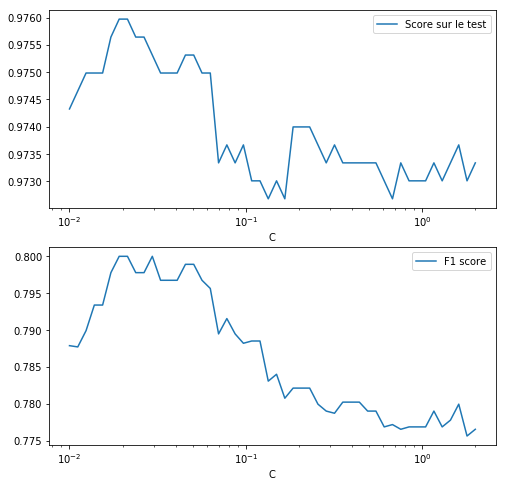

In [47]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(C_list,Score_list,label='Score sur le test')
plt.xscale("log")
plt.xlabel('C')
plt.legend()

plt.subplot(2,1,2)
plt.plot(C_list,F1_list,label='F1 score')
plt.xscale("log")
plt.xlabel('C')
plt.legend()

On voit que le C optimal se situe entre 0 et 0.06. On choisit finalement la valeur de C en calculant les scores moyens sur 10 train/test splits différents pour chaque valeur de C.

In [55]:
C_list=np.arange(0.01,0.07,0.005)
F1_list=[]
Score_list=[]

for c in C_list:
    Score_moyen=[]
    F1_moyen=[]
    for i in range(10):
        X_train, X_test, label_train, label_test =sklearn.model_selection.train_test_split(X,label,test_size=0.3)
        RegLog = sklearn.linear_model.LogisticRegression(penalty='l2',C=c)
        RegLog.fit(X_train,label_train)
    
        probs_y=RegLog.predict_proba(X_test)
        precision, recall, thresholds = precision_recall_curve(label_test, probs_y[:,1]) 
        f_score= (2*precision*recall)/(precision+recall)
        Max_f_score = max(f_score)
        threshold = thresholds[np.argmax(f_score)]

        predict_y= (probs_y[:,1]>threshold)*1
        Score = (1 - sklearn.metrics.mean_squared_error(label_test,predict_y))

        F1_moyen.append(Max_f_score)
        Score_moyen.append(Score)
        
    F1_list.append(np.mean(F1_moyen))
    Score_list.append(np.mean(Score_moyen))

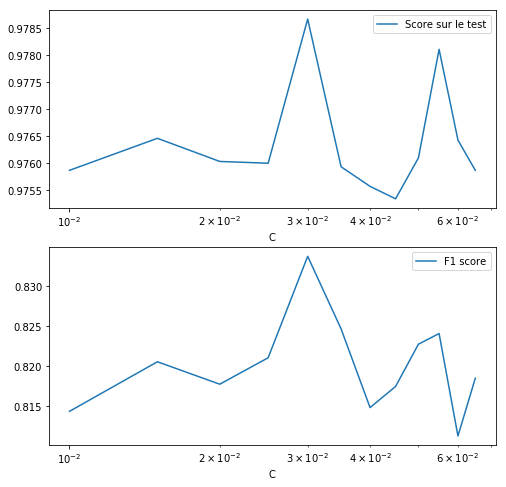

In [57]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(C_list,Score_list,label='Score sur le test')
plt.xscale("log")
plt.xlabel('C')
plt.legend()

plt.subplot(2,1,2)
plt.plot(C_list,F1_list,label='F1 score')
plt.xscale("log")
plt.xlabel('C')
plt.legend()

On choisit donc C=0.03.

On va maintenant effectuer la même démarche avec un classifieur SVM avec un kernel "rbf", pour voir si les performances sont meilleures.

In [59]:
C_list=np.geomspace(0.01,2,25)
F1_list=[]
Threshold_list=[]
Score_list=[]

X_train, X_test, label_train, label_test =sklearn.model_selection.train_test_split(X,label,test_size=0.3)
for c in C_list:
    SVM = sklearn.svm.SVC(kernel='rbf',C=c,probability=True)
    SVM.fit(X_train,label_train)
    
    probs_y=SVM.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(label_test, probs_y[:,1]) 
    f_score= (2*precision*recall)/(precision+recall)
    Max_f_score = max(f_score)
    threshold = thresholds[np.argmax(f_score)]

    predict_y= (probs_y[:,1]>threshold)*1
    Score = (1 - sklearn.metrics.mean_squared_error(label_test,predict_y))
    
    F1_list.append(Max_f_score)
    Threshold_list.append(threshold)
    Score_list.append(Score)

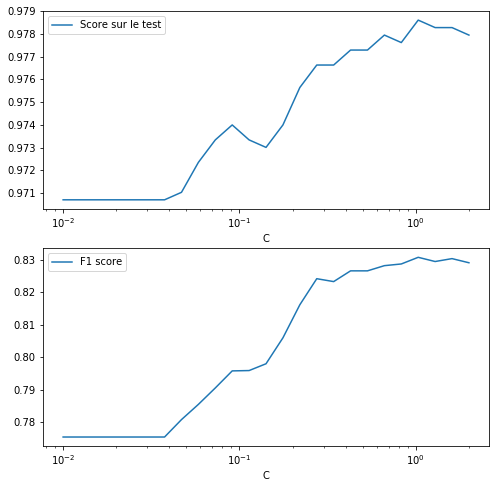

In [60]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(C_list,Score_list,label='Score sur le test')
plt.xscale("log")
plt.xlabel('C')
plt.legend()

plt.subplot(2,1,2)
plt.plot(C_list,F1_list,label='F1 score')
plt.xscale("log")
plt.xlabel('C')
plt.legend()

On choisit donc C=1 pour le classifieur SVM.

A priori, le classifieur SVM ne permet pas d'avoir un F score ou une précision plus élevée qu'une régression logistique.

### Exportation de la prédiction

On commence par fit notre classifieur sur l'ensemble des données d'entrainement.

In [62]:
estimator = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.03)
estimator.fit(X, label)

LogisticRegression(C=0.03, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

On prédit ensuite la probabilité qu'une tumeur soit présente pour chaque tile de chaque slide. On stocke ces prédictions dans une liste contenant, pour chaque slide, les prédictions pour chacune de ses tiles.

In [63]:
prediction_test_tiles=[]
for i in range(len(features_test)):
    prediction_test_tiles.append(estimator.predict_proba(features_test[i])[:, 1])

In [65]:
print(len(prediction_test_tiles)) #Correspond aux nombre de slides (donc de patients) dans le testt
print(len(prediction_test_tiles[0])) #Correspond aux nombre de tiles pour la slide 0

120
964


L'output devant être soumis sur le site est un vecteur de longueur 120, dont l'élément $i$ est la probabilité que la patient $i$ ait une tumeur. 

Il nous faut donc trouver une relation entre la probabilité qu'un patient ait une tumeur et les probabilités qu'une tumeur soit présente dans chacune de ses tiles (information dont l'on dispose). Notre premier raisonnement fut le suivant : on note $Y$ la variable aléatoire correspondant au nombre de tumeurs d'un patient, et $X_k$ le nombre de tumeurs dans la tile $k$ du patient.

On a donc:
$$ P( Le~patient~a~une~tumeur) = P(Y \neq 0) $$
$$ = 1 - P(Y=0) $$
$$ = 1 - P( (X_1=0) \cap ... \cap (X_n=0))$$
$$ = 1 - \prod_{i=1}^n P(X_i=0) $$ en considérant les tiles indépendantes
$$ = 1 - \prod_{i=1}^n ( 1 - p_i ) $$

$p_i$ étant la probabilité calculée par le classifieur.

Cependant, cette formule ne donne pas de résultats concluants, à cause du trop grand nombre de tiles: le produit des $(1-p_i)$ est en pratique toujours égal à 1 ou à 0. 

Finalement, nous avons testé les 3 méthodes suivantes :

-> La probabilité que le patient ait une tumeur est égale à la probabilité maximum sur les tiles

-> La probabilité que le patient ait une tumeur est égale à la moyenne des 5 plus grandes probabilités sur les tiles

-> La probabilité que le patient ait une tumeur est égale à la 5eme plus grande probabilité sur les tiles

Or, la première méthode a pour inconvénient d'être fortement sensible aux faux positifs: en effet, si un patient ne possède qu'une seule tile pour laquelle les chances d'avoir une tumeur sont grandes, alors on est sans doute en présence d'un faux positif. En effet, si un patient possède des tumeurs, alors il y a de fortes chances que celles ci soient présentes sur plusieurs tiles.

Nous avons donc finalement choisi d'utiliser la deuxième méthode, après avoir comparé ses résultats avec la 3ème.

Création de l'output : 

In [66]:
prediction_test=[]
for i in prediction_test_tiles:
    prediction_test.append(np.mean(np.sort(i)[-5:]))
    
test_output = pd.DataFrame({"ID": Id_test, "Target": prediction_test})
test_output.set_index("ID", inplace=True)
test_output.to_csv(path + "\\preds_test.csv")